In [1]:
%load_ext autoreload
%autoreload 1
%aimport ecg_get_data
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
%aimport Net
%aimport select_dataset
import select_dataset
import Models 
import Net
from train_test_validat import *
from self_attention import *
import  ecg_get_data 
import matplotlib.pyplot as plt
import ecg_plot

import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import pandas as pd

import time
import os
import gc

random_seed = 2
torch.manual_seed(random_seed)    # reproducible
torch.cuda.manual_seed_all(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime()) 

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_path = './model/'+time_str
log_path = './log/'+  time_str
ECG_root = '/workspace/data/Preprocess_HTN/data/ECG'
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [3]:
data = select_dataset.splite_dataset('/workspace/data/Preprocess_HTN/data/',True)
test_list = data.__get_test_file_list__(False)
# print(valid_list)
valid_list,train_list,addition_train_list = data.__get_VT_file_list__(0,False)


	
 orginal   fliteryears
  33342       8479   
	
 orginal    fliterID 
   509        425    
	
 orginal    fliterID 
   8479       7064   
	
       HTN  NHTN 
test   425  7064 
	
 orginal   fliteryears
  65933      11329   
	
 orginal    fliterID 
   1354       1221   
	
 orginal    fliterID 
  11329       9246   
	
       HTN  NHTN 
train 1221  9246 
valid   0     0  
 add    0     0  


In [5]:
test_infos_df = data.__read_infos__(test_list)
test_infos_df = test_infos_df.dropna(subset=['years']) #删除years== nan
test_infos_df.loc[~(test_infos_df['years'].str.contains('岁')),'years']='0岁' #不含有岁的（天周月）改为"0岁"
test_infos_df['years'].replace(regex=True,inplace=True,to_replace=r'岁',value=r'') #删除"岁"
test_infos_df['gender'].replace(regex=True,inplace=True,to_replace=r'男',value=r'1') #替换男
test_infos_df['gender'].replace(regex=True,inplace=True,to_replace=r'女',value=r'0') #替换男

train_infos_df = data.__read_infos__(train_list)
train_infos_df = train_infos_df.dropna(subset=['years']) #删除years== nan
train_infos_df.loc[~(train_infos_df['years'].str.contains('岁')),'years']='0岁' #不含有岁的（天周月）改为"0岁"
train_infos_df['years'].replace(regex=True,inplace=True,to_replace=r'岁',value=r'') #删除"岁"
train_infos_df['gender'].replace(regex=True,inplace=True,to_replace=r'男',value=r'1') #替换男
train_infos_df['gender'].replace(regex=True,inplace=True,to_replace=r'女',value=r'0') #替换男


<AxesSubplot:ylabel='Density'>

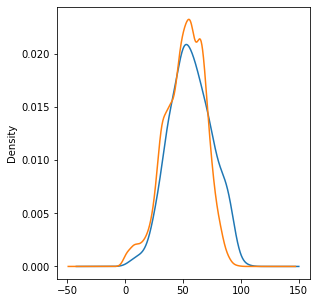

In [8]:
plt.figure(figsize=(10,5))
plt.subplot2grid((1,2),(0,0))
(pd.to_numeric(test_infos_df.years[test_infos_df['ECG_path'].str.contains('_HTN')])).plot(kind = 'kde')
(pd.to_numeric(test_infos_df.years[test_infos_df['ECG_path'].str.contains('_NHTN')])).plot(kind = 'kde')


<AxesSubplot:ylabel='gender'>

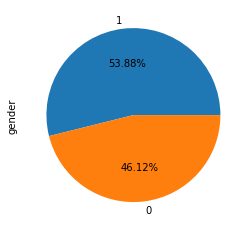

In [9]:
test_infos_df.gender[test_infos_df['ECG_path'].str.contains('_HTN')].value_counts().plot.pie(autopct = '%1.2f%%')

<AxesSubplot:ylabel='gender'>

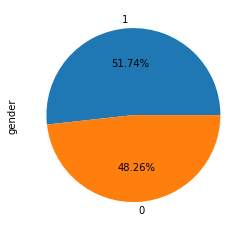

In [10]:
test_infos_df.gender[test_infos_df['ECG_path'].str.contains('_NHTN')].value_counts().plot.pie(autopct = '%1.2f%%') 

<AxesSubplot:ylabel='Density'>

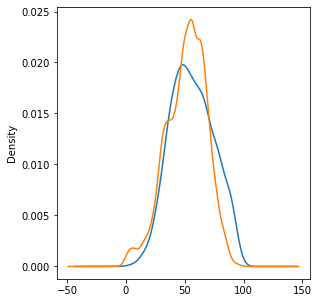

In [11]:
plt.figure(figsize=(10,5))
plt.subplot2grid((1,2),(0,0))
(pd.to_numeric(train_infos_df.years[train_infos_df['ECG_path'].str.contains('_HTN')])).plot(kind = 'kde')
(pd.to_numeric(train_infos_df.years[train_infos_df['ECG_path'].str.contains('_NHTN')])).plot(kind = 'kde')

<AxesSubplot:ylabel='gender'>

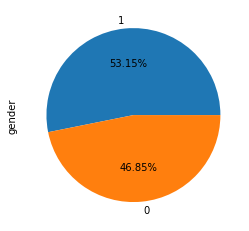

In [12]:
train_infos_df.gender[train_infos_df['ECG_path'].str.contains('_HTN')].value_counts().plot.pie(autopct = '%1.2f%%')

<AxesSubplot:ylabel='gender'>

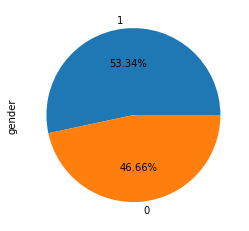

In [13]:
train_infos_df.gender[train_infos_df['ECG_path'].str.contains('_NHTN')].value_counts().plot.pie(autopct = '%1.2f%%')

In [ ]:
import math
for fold in range(FOLDS):
    #每个人fold都重新抽取
    NET[fold].to(DEVICE)
    valid_list,train_list,addition_train_list = data.__get_VT_file_list__(0.2,True)
    valid_Dataset = ecg_get_data.ECG_Dataset(ECG_root,valid_list,EcgChannles_num,EcgLength_num)
    train_Dataset = ecg_get_data.ECG_Dataset(ECG_root,train_list,EcgChannles_num,EcgLength_num,ECG_root,addition_train_list)
    
    train_dataloader = Data.DataLoader(dataset=train_Dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=16,pin_memory=True)
    valid_dataloader = Data.DataLoader(dataset=valid_Dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=16,pin_memory=True)
    #test_dataloader = Data.DataLoader(dataset=test_Dataset, batch_size=25, shuffle=True,num_workers=1,pin_memory=True)
    early_stopping = EarlyStopping(PATIENCE, verbose=True, model_path=model_path, delta=0, positive=False)
    optimizer  = torch.optim.Adam(NET[fold].parameters(), lr=LR,weight_decay=1e-2)  
    
    warm_up_iter = 6
    T_max = 16	# 周期
    lr_max = 1e-3	# 最大值
    lr_min = 1e-5	# 最小值
    lambda0 = lambda cur_iter: (cur_iter / warm_up_iter)*lr_max if  cur_iter < warm_up_iter else \
        (lr_min + 0.5*(lr_max-lr_min)*(1.0+math.cos( (cur_iter-warm_up_iter)/(T_max-warm_up_iter)*math.pi)))/0.1
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda0)
    criterion = torch.nn.CrossEntropyLoss()   

    for epoch in range(1,EPOCHS):
        time_all=0
        start_time = time.time()
        y_true,y_pred,train_loss,train_acc = train_model(train_dataloader, NET[fold], criterion, optimizer,DEVICE) # type: ignore # 训练模型
        time_all = time.time()-start_time
        C0 = confusion_matrix(y_true,y_pred)
        F1_score_train =f1_score(y_true, y_pred, average='macro')#F1分数
        y_true,y_pred,validate_loss,validate_acc = eval_model(valid_dataloader,criterion,NET[fold],DEVICE) # 验证模型
        F1_score_valid =f1_score(y_true, y_pred, average='macro')#F1分数
        writer.add_scalars(main_tag=str(fold)+'_Loss',tag_scalar_dict={'train': train_loss,'validate': validate_loss},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_Accuracy',tag_scalar_dict={'train': train_acc,'validate': validate_acc},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_LearningRate',tag_scalar_dict={'LR': optimizer.state_dict()['param_groups'][0]['lr']},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_F1_score',tag_scalar_dict={'train':F1_score_train,'validate': F1_score_valid},global_step=epoch)
        print('- Epoch: %d - Train_loss: %.5f - Train_acc: %.5f - F1 score: %.5f - Val_loss: %.5f - Val_acc: %.5f - F1 score: %.5f - T_Time: %.5f' %(epoch,train_loss,train_acc,F1_score_train,validate_loss,validate_acc,F1_score_valid,time_all))
        print('当前学习率：%.8f' %optimizer.state_dict()['param_groups'][0]['lr'])
        C1 = confusion_matrix(y_true,y_pred)
        print('train:\n',C0)
        print('validate:\n',C1)
        
        scheduler.step() # 学习率迭代
        #是否满足早停法条件
        if(early_stopping(validate_loss,NET[fold],fold)):
            print("Early stopping")
            break

    print('Fold %d Training Finished' %(fold+1))
    torch.cuda.empty_cache()# 清空显卡cuda
print('Training Finished')

In [ ]:
test_Dataset = ecg_get_data.ECG_Dataset(ECG_root,test_list,EcgChannles_num,EcgLength_num)
ECG,label = test_Dataset.__getitem__(1)
#inf,path = train_Dataset.get_basic_inf(55)
#ecg_plot.plot(ECG*3500/1000, sample_rate = 500, title = "test",row_height= 10,show_grid=True,show_separate_line=True)
label
#ecg_plot.save_as_png(inf[1],'/workspace/data/OneDrive - mail.hfut.edu.cn/ECG/Interpretable_HTN//PNG_ECG/',dpi = 100)

In [ ]:
BATCH_SIZE = 64

FOLDS = 1
EPOCHS = 200  
PATIENCE = 100
LR = 0.01

In [ ]:
from torch.utils.tensorboard import SummaryWriter   
os.makedirs(model_path, exist_ok=True)
writer = SummaryWriter(log_path)
from torchsummary import summary

In [ ]:
torch.cuda.empty_cache()# 清空显卡cuda
#NET = [Models.channels_split_ATT_CNN_(mark=True) for i in range(FOLDS)]
# NET = [
#     Net.channels_branch_CNN(True)
#     ]
# NET = [ 
#         Models.channels_split_ATT_CNN_linear_avgpool_for_grad(mark=True,extract_dim=16,hdim=32)
#       ]
# NET = [Models.resnet18(12,64,2)]
#NET = [Models.channels_split_ATT_CNN_(mark=True) for i in range(FOLDS)]
#NET =[Models.Informer(1)]
NET = [Net.channels_branch_CNN(True)]

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix
import pytorch_warmup as warmup

torch.cuda.empty_cache()# 清空显卡cuda
for fold in range(FOLDS):
    NET[fold].to(DEVICE)
    train_size= int(0.8*len(x_Dataset))
    validate_size=(len(x_Dataset)) - train_size
    train_Dataset,valid_Dataset=torch.utils.data.random_split(x_Dataset,[train_size,validate_size])    # type: ignore
    train_dataloader = Data.DataLoader(dataset=train_Dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=5,pin_memory=True)
    valid_dataloader = Data.DataLoader(dataset=valid_Dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=5,pin_memory=True)
    test_dataloader = Data.DataLoader(dataset=test_Dataset, batch_size=25, shuffle=True,num_workers=5,pin_memory=True)
    early_stopping = EarlyStopping(PATIENCE, verbose=True, model_path=model_path, delta=0)    
    optimizer  = torch.optim.Adadelta(NET[fold].parameters(), lr=LR,weight_decay=1e-2)  
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[EPOCHS//5], gamma=0.1)
    warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)
    warmup_scheduler.last_step = -1 # initialize the step counter
    
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 7, gamma=0.5)#等间隔调整学习率
    # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=optimizer,base_lr=1e-8,max_lr=1e-3,step_size_down=16,step_size_up=16 ,cycle_momentum=False)
    criterion = torch.nn.CrossEntropyLoss()   
    
    best_loss = 3
    for epoch in range(1,EPOCHS):
        time_all=0
        start_time = time.time()
        lr_scheduler.step(epoch-1)
        warmup_scheduler.dampen()
        
        train_loss,train_acc = train_model(train_dataloader, NET[fold], criterion, optimizer,DEVICE) # 训练模型

        time_all = time.time()-start_time
        y_true,y_pred,validate_loss,validate_acc = eval_model(valid_dataloader,criterion,NET[fold],DEVICE) # 测试模型
        y_true_test,y_pred_test,loss_test,acc_test = eval_model(valid_dataloader,criterion,NET[fold],DEVICE) # 测试模型
        F1_score =f1_score(y_true, y_pred, average='macro')#F1分数
        F1_score_test =f1_score(y_true_test, y_pred_test, average='macro')#F1分数
        writer.add_scalars(main_tag=str(fold)+'_Loss',tag_scalar_dict={'train': train_loss,'validate': validate_loss,'test': loss_test},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_Accuracy',tag_scalar_dict={'train': train_acc,'validate': validate_acc,'test': acc_test},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_LearningRate',tag_scalar_dict={'LR': optimizer.state_dict()['param_groups'][0]['lr']},global_step=epoch)
        writer.add_scalars(main_tag=str(fold)+'_F1_score',tag_scalar_dict={'validate': F1_score,'test':F1_score_test},global_step=epoch)
        print('- Epoch: %d - Train_loss: %.5f - Train_acc: %.5f - Val_loss: %.5f - Val_acc: %5f - T_Time: %.5f' %(epoch,train_loss,train_acc,validate_loss,validate_acc,time_all))
        print('F1 score: %f' %(F1_score))
        print('当前学习率：%.8f' %optimizer.state_dict()['param_groups'][0]['lr'])
        C1 = confusion_matrix(y_true,y_pred)
        C2 = confusion_matrix(y_true_test,y_pred_test)
        print('validate:',C1,'  dtest:' ,C2)
        if validate_loss < best_loss:
            best_loss = validate_loss
            print('Find better model in Epoch {0}, saving model.'.format(epoch))
            #torch.save(NET[fold],  model_path+'/all_best_model_' + str(fold) + '.pt')  # 保存最优模型
            torch.save(NET[fold].state_dict(), model_path+'/parameter_best_model_' + str(fold) + '.pt')
        if C2[1,1]>300 and C2[0,0]>
        #是否满足早停法条件
        if(early_stopping(F1_score,NET[fold],fold)):
            print("Early stopping")
            break

    print('Fold %d Training Finished' %(fold+1))
    torch.cuda.empty_cache()# 清空显卡cuda
print('Training Finished')

In [ ]:
class exectal_attention(nn.Module):
    def __init__(self,in_channels,out_channels,menmory_dim):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.menmory_dim = menmory_dim
        self.M_k = nn.Linear(self.out_channels, self.menmory_dim,bias=False)
        self.M_v = nn.Linear(self.menmory_dim, self.out_channels,bias=False)
        self.query = nn.Linear(self.in_channels, self.out_channels,bias=False)
        self.softmax = nn.Softmax(dim=1)
    def l1_norm(self,aij,dim=2):
        aij_norm= aij/torch.sum(aij,dim=dim)  # type: ignore
        return aij_norm
    def forward(self, x):
        x = self.query(x)
        attn = self.M_k(x)
        attn = self.softmax(attn)
        attn = self.l1_norm(attn,dim=2)
        out = self.M_v(x)
        return out,attn


In [1]:
%load_ext autoreload
%autoreload 1
%aimport ecg_get_data
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
%aimport cam
%aimport Net
%aimport select_dataset
import select_dataset
import Net
import random
import Models 
from train_test_validat import *
import  ecg_get_data 
import ECGplot
import cam 

import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt

random_seed = 2
torch.manual_seed(random_seed)    # reproducible
torch.cuda.manual_seed_all(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

test_npy_path =  './data/test/' #路径
xml_path = './xml/xml/'
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [7]:
DEVICE = 'cpu'

In [8]:
data = select_dataset.splite_dataset('/workspace/data/Preprocess_HTN/data/',True)
test_list = data.__get_test_file_list__(False)
test_Dataset = ecg_get_data.ECG_Dataset('/workspace/data/Preprocess_HTN/data/ECG',test_list,EcgChannles_num,EcgLength_num)

	
 orginal   fliteryears
  33342       4347   
	
 orginal    fliterID 
   509        425    
	
 orginal    fliterID 
   4347       3807   
	
       HTN  NHTN 
test   425  3807 
npys:{%d} 4232


In [9]:
testmodel = (Net.MLBFNet(True,res = True,se = True,Dropout_rate = 0.25)).to(DEVICE)  # type: ignore
# testmodel = (Models.resnet18(12,64,2)).to(DEVICE)
testmodel.load_state_dict(torch.load("./model/20221024_144407/parameter_EarlyStoping_0.pt"))

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# TEST_BATCH_SIZE = test_Dataset.npys.__len__()
test_dataloader = Data.DataLoader(dataset=test_Dataset, batch_size=1)

test_acc = []   
criterion = torch.nn.CrossEntropyLoss() 
possibility,y_true,y_pred,test_loss,test_acc, = eval_model_possibility(test_dataloader,criterion,testmodel,DEVICE) # 测试模型
print('loss =',test_loss,'acc =',test_acc)
print('f1_macro =',f1_score(y_true, y_pred, average='macro')) 

In [15]:
import cleanlab
cleanlab.filter.find_label_issues(y_true,possibility[y_pred])

SyntaxError: invalid syntax (4152454361.py, line 1)